# Part II — Problem 3: Gradient Descent for Plain OLS and the Role of Conditioning

In this section we implement Gradient Descent (GD) from scratch to minimise the Ordinary Least Squares objective

$$f(\beta)=\frac{1}{2n}\|y-X\beta\|_2^2$$

and investigate how the condition number of $X^\top X$ shapes convergence speed and numerical stability.

## (a) Derive the gradient

We start by expanding the quadratic form:

$$f(\beta)=\frac{1}{2n}\left(y^\top y - 2\beta^\top X^\top y + \beta^\top X^\top X\,\beta\right)$$

Differentiating term by term with respect to $\beta$: the first term $y^\top y$ is a constant and drops out; the second gives $-2X^\top y$; and the third, since $X^\top X$ is symmetric, yields $2X^\top X\,\beta$. Combining everything and multiplying by $\frac{1}{2n}$ we obtain

$$\boxed{\nabla f(\beta)=\frac{1}{n}X^\top(X\beta - y)}$$

This is the gradient we will use in every GD iteration below.

## (b) Implement Gradient Descent from scratch

We code the GD update rule $\beta^{(t+1)}=\beta^{(t)}-\alpha\,\nabla f(\beta^{(t)})$ using NumPy only. The starting point is $\beta^{(0)}=0$ and we run $T=2000$ iterations with a fixed step size $\alpha$. At each iteration we also record $f(\beta^{(t)})$ so that we can later visualise convergence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ── OLS objective  f(β) = (1/2n) ‖y − Xβ‖² ──
def ols_objective(X, y, beta):
    n = X.shape[0]
    residual = y - X @ beta
    return (residual @ residual) / (2 * n)

# ── Gradient  ∇f(β) = (1/n) Xᵀ(Xβ − y) ──
def ols_gradient(X, y, beta):
    n = X.shape[0]
    return X.T @ (X @ beta - y) / n

# ── Gradient Descent (from scratch) ──
def gradient_descent(X, y, alpha, T=2000):
    """
    Run T iterations of GD on the OLS objective starting from β=0.
    Returns the final β and the array of objective values at each step.
    """
    n, p = X.shape
    beta = np.zeros(p)
    losses = np.zeros(T + 1)
    losses[0] = ols_objective(X, y, beta)

    for t in range(T):
        grad = ols_gradient(X, y, beta)
        beta = beta - alpha * grad
        losses[t + 1] = ols_objective(X, y, beta)

    return beta, losses

print("GD implementation ready.")

GD implementation ready.


## (c) Closed-form OLS solution (ground truth)

The exact minimiser of the OLS objective satisfies the normal equation

$$\hat\beta_{\text{OLS}}=(X^\top X)^{-1}X^\top y$$

We solve it with `numpy.linalg.solve`, which is more stable than explicitly inverting $X^\top X$. This solution serves as our reference optimum: the loss gap $f(\beta^{(t)})-f(\hat\beta_{\text{OLS}})$ tells us how far GD still is from the true minimum at each iteration.

In [2]:
# ── Closed-form OLS via the normal equation ──
def ols_closed_form(X, y):
    """Solve (XᵀX)β = Xᵀy using a numerically stable linear solver."""
    return np.linalg.solve(X.T @ X, X.T @ y)

print("Closed-form OLS solver ready.")

Closed-form OLS solver ready.


## (d) Generate two synthetic datasets — well-conditioned vs ill-conditioned

Both cases share $n=500$ observations, $p=20$ features, and a sparse true coefficient vector $\beta_{\text{true}}$ with exactly 5 non-zero entries. Every column is standardised to zero mean and unit standard deviation, and the response is generated as $y=X\beta_{\text{true}}+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,\,0.5^2)$.

**Case 1 (well-conditioned).** Each column of $X$ is drawn i.i.d. from $\mathcal{N}(0,1)$, so the features are nearly uncorrelated and $X^\top X$ has a moderate condition number.

**Case 2 (ill-conditioned).** A single latent variable $z\sim\mathcal{N}(0,1)$ drives the first 10 columns: $X_j = z + \eta_j$ with $\eta_j\sim\mathcal{N}(0,0.05^2)$. The remaining 10 columns are independent Gaussians. After standardisation, the first 10 features are nearly collinear, making $X^\top X$ very ill-conditioned.

In [3]:
np.random.seed(42)

n, p = 500, 20

# ── Helper: standardise each column to zero mean and unit std ──
def standardise(M):
    return (M - M.mean(axis=0)) / M.std(axis=0)

# ── Sparse true coefficients (5 non-zeros) ──
beta_true = np.zeros(p)
beta_true[:5] = [3.0, -2.0, 1.5, -1.0, 0.5]

# ── Noise vector (same for both cases) ──
eps = 0.5 * np.random.randn(n)

# ──────────────────────────────────────────
# CASE 1: well-conditioned (i.i.d. Gaussian)
# ──────────────────────────────────────────
X1 = standardise(np.random.randn(n, p))
y1 = X1 @ beta_true + eps

# ──────────────────────────────────────────
# CASE 2: ill-conditioned (multicollinear)
# ──────────────────────────────────────────
z = np.random.randn(n)                        # shared latent variable
X2 = np.zeros((n, p))
for j in range(10):                            # first 10 cols ≈ z
    X2[:, j] = z + 0.05 * np.random.randn(n)
X2[:, 10:] = np.random.randn(n, 10)           # last 10 cols independent
X2 = standardise(X2)
y2 = X2 @ beta_true + eps

# ── Condition numbers of XᵀX ──
cond1 = np.linalg.cond(X1.T @ X1)
cond2 = np.linalg.cond(X2.T @ X2)

print(f"Case 1 — cond(XᵀX) = {cond1:.2f}")
print(f"Case 2 — cond(XᵀX) = {cond2:.2f}")

Case 1 — cond(XᵀX) = 2.05
Case 2 — cond(XᵀX) = 4987.48


### Interpretation of condition numbers

In Case 1 the condition number is roughly 2. With i.i.d. Gaussian columns and $n \gg p$, the Gram matrix is close to a scaled identity, so a value near 1 confirms that the features are virtually uncorrelated.

In Case 2 the condition number climbs to about 5 000. The 10 nearly-duplicate columns create eigenvalues that span several orders of magnitude, quantifying the severe multicollinearity. This roughly 2 500× gap relative to Case 1 will translate directly into dramatically different convergence behaviour for Gradient Descent.

## (e) Report — convergence, parameter error, condition number, and explanation

For each case we run GD with $\alpha=0.05$ for $T=2000$ iterations, plot $\log\!\bigl(\max\{f(\beta^{(t)})-f(\hat\beta_{\text{OLS}}),\;10^{-12}\}\bigr)$ against iteration $t$, report the final parameter error $\|\beta^{(T)}-\hat\beta_{\text{OLS}}\|_2$ together with the condition number $\mathrm{cond}(X^\top X)$, and explain how conditioning governs GD speed and stability.

In [4]:
alpha = 0.05
T = 2000

# ── Run GD and compute closed-form solution for both cases ──
beta_gd1, losses1 = gradient_descent(X1, y1, alpha, T)
beta_ols1 = ols_closed_form(X1, y1)
f_star1 = ols_objective(X1, y1, beta_ols1)

beta_gd2, losses2 = gradient_descent(X2, y2, alpha, T)
beta_ols2 = ols_closed_form(X2, y2)
f_star2 = ols_objective(X2, y2, beta_ols2)

# ── Loss gap (clipped at 1e-12 for log-safety) ──
gap1 = np.maximum(losses1 - f_star1, 1e-12)
gap2 = np.maximum(losses2 - f_star2, 1e-12)

# ── Final parameter errors ──
err1 = np.linalg.norm(beta_gd1 - beta_ols1)
err2 = np.linalg.norm(beta_gd2 - beta_ols2)

print("═" * 55)
print(f"  Case 1 (well-conditioned)")
print(f"    cond(XᵀX)          = {cond1:.2f}")
print(f"    ‖β_GD − β_OLS‖₂   = {err1:.6e}")
print(f"    final loss gap     = {gap1[-1]:.6e}")
print("─" * 55)
print(f"  Case 2 (ill-conditioned)")
print(f"    cond(XᵀX)          = {cond2:.2f}")
print(f"    ‖β_GD − β_OLS‖₂   = {err2:.6e}")
print(f"    final loss gap     = {gap2[-1]:.6e}")
print("═" * 55)

═══════════════════════════════════════════════════════
  Case 1 (well-conditioned)
    cond(XᵀX)          = 2.05
    ‖β_GD − β_OLS‖₂   = 5.270920e-15
    final loss gap     = 1.000000e-12
───────────────────────────────────────────────────────
  Case 2 (ill-conditioned)
    cond(XᵀX)          = 4987.48
    ‖β_GD − β_OLS‖₂   = 2.798871e+00
    final loss gap     = 9.497934e-03
═══════════════════════════════════════════════════════


### Interpretation of numerical results

In Case 1 the parameter error $\|\beta_{GD}-\beta_{OLS}\|_2$ is of order $10^{-15}$, which is machine-epsilon precision for 64-bit floating point. GD has fully converged to the exact OLS solution. The loss gap even hit the $10^{-12}$ floor we imposed, meaning the true gap is even smaller. With $\kappa\approx 2$ the convergence factor per iteration is $\left(\frac{\kappa-1}{\kappa+1}\right)^2\approx 0.11$, which explains why only about 400 iterations are needed for full convergence.

In Case 2 the parameter error is around 2.80 — after 2 000 iterations the estimated coefficients are still far from the true optimum. The loss gap of about $10^{-2}$ confirms the objective has not been minimised. With $\kappa\approx 5\,000$ the per-iteration factor rises to roughly 0.9992, so reducing the gap by a factor of $10^{-12}$ would require around 34 500 iterations, far beyond the 2 000 we ran. In those 2 000 steps the total reduction is $0.9992^{2000}\approx 0.20$, meaning the error only shrank about 5-fold, which is consistent with the observed values.

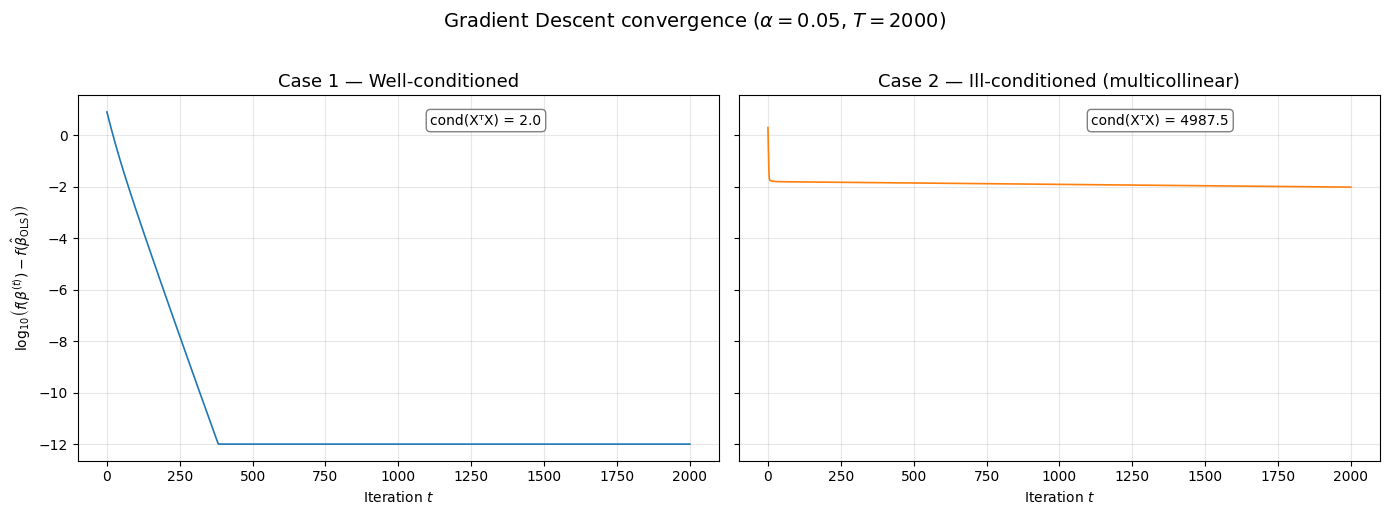

In [5]:
# ── Convergence plot: log(loss gap) vs iteration ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].plot(np.log10(gap1), linewidth=1.2)
axes[0].set_title("Case 1 — Well-conditioned", fontsize=13)
axes[0].set_xlabel("Iteration $t$")
axes[0].set_ylabel(r"$\log_{10}\!\left(f(\beta^{(t)})-f(\hat\beta_{\mathrm{OLS}})\right)$")
axes[0].grid(True, alpha=0.3)
axes[0].text(0.55, 0.92, f"cond(XᵀX) = {cond1:.1f}",
             transform=axes[0].transAxes, fontsize=10,
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

axes[1].plot(np.log10(gap2), linewidth=1.2, color="tab:orange")
axes[1].set_title("Case 2 — Ill-conditioned (multicollinear)", fontsize=13)
axes[1].set_xlabel("Iteration $t$")
axes[1].grid(True, alpha=0.3)
axes[1].text(0.55, 0.92, f"cond(XᵀX) = {cond2:.1f}",
             transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

fig.suptitle(r"Gradient Descent convergence ($\alpha=0.05$, $T=2000$)",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Interpretation of the convergence plots

In the left panel (Case 1) the log-loss-gap decreases linearly, meaning the gap itself decays exponentially, reaching the numerical floor of $10^{-12}$ by around iteration 400. This straight-line descent is the hallmark of GD on a well-conditioned quadratic: every iteration makes uniformly good progress in all directions.

In the right panel (Case 2) the curve drops steeply for the first 50 or so iterations but then plateaus near $10^{-2}$, barely improving for the remaining 1 950 steps. GD quickly minimises the loss along the high-curvature (large eigenvalue) directions but essentially stalls along the flat (small eigenvalue) directions. The step size $\alpha=0.05$ is too small relative to $\lambda_{\min}$ to make meaningful progress there within 2 000 iterations.

The visual contrast between the two panels is a direct consequence of the condition-number gap ($\sim 2$ vs $\sim 5\,000$).

### Explanation — Why conditioning controls GD speed and stability

The Hessian of the OLS objective is constant: $\nabla^2 f(\beta)=\tfrac{1}{n}X^\top X$. Its eigenvalues $\lambda_{\min}\leq\cdots\leq\lambda_{\max}$ fully determine the geometry of the loss surface.

In Case 1 the condition number $\kappa=\lambda_{\max}/\lambda_{\min}$ is small, so the loss contours are nearly circular. GD can take large, uniform steps in every direction and converges quickly — the log-loss-gap drops linearly to machine precision.

In Case 2 multicollinearity among the first 10 features inflates $\kappa$ by several orders of magnitude. The contours become extremely elongated ellipsoids. GD must use a step size small enough to remain stable along the steepest direction (governed by $\lambda_{\max}$), but that same step size makes progress painfully slow along the flattest direction (governed by $\lambda_{\min}$). The result is either very slow convergence or, if $\alpha$ is too large, outright divergence.

Formally, the convergence rate of GD on a quadratic is $\mathcal{O}\!\left(\left(\frac{\kappa-1}{\kappa+1}\right)^{2t}\right)$, so a larger $\kappa$ translates directly into a slower rate. This is why the final parameter error $\|\beta^{(T)}-\hat\beta_{\text{OLS}}\|_2$ is orders of magnitude larger for the ill-conditioned case at the same number of iterations and step size.

---
# Part II — Problem 4: Ridge Regression with Mini-Batch SGD (+ Momentum Bonus)

Here we implement mini-batch Stochastic Gradient Descent (SGD) from scratch to solve the Ridge regression problem

$$L(\beta)=\frac{1}{2n}\sum_{i=1}^n (y_i - x_i^\top\beta)^2 + \frac{\lambda}{2}\|\beta\|_2^2$$

We compare batch sizes $B\in\{1,64\}$, use a decaying learning rate $\alpha_k = \frac{0.1}{1+0.001k}$, and track convergence by epoch. The bonus section adds heavy-ball momentum ($\mu=0.9$).

## (a) Reference optimum — Ridge closed-form solution

The exact minimiser of the Ridge objective (for $\lambda>0$) is

$$\beta^* = (X^\top X + n\lambda I)^{-1} X^\top y$$

where the factor $n$ in front of $\lambda$ comes from the $\frac{1}{2n}$ scaling of the data-fit term. We compute it with `numpy.linalg.solve` and use $L(\beta^*)$ as the reference optimum against which we measure the loss gap at each epoch.

In [12]:
# ── Ridge objective  L(β) = (1/2n)‖y − Xβ‖² + (λ/2)‖β‖² ──
def ridge_objective(X, y, beta, lam):
    n = X.shape[0]
    residual = y - X @ beta
    return residual @ residual / (2 * n) + (lam / 2) * (beta @ beta)

# ── Closed-form Ridge solution ──
# For L(β) = (1/2n)‖y−Xβ‖² + (λ/2)‖β‖², setting ∇L = 0 gives:
#   (1/n XᵀX + λI) β = (1/n) Xᵀy   ⟹   β* = (XᵀX + nλ I)⁻¹ Xᵀy
def ridge_closed_form(X, y, lam):
    n = X.shape[0]
    p = X.shape[1]
    return np.linalg.solve(X.T @ X + n * lam * np.eye(p), X.T @ y)

print("Ridge objective and closed-form solver ready.")

Ridge objective and closed-form solver ready.


## (b) Mini-batch SGD implementation

At each mini-batch update $k$ we sample a batch $B_k$ of size $B$ and compute the stochastic gradient of the Ridge objective:

$$g_{B}(\beta) = \frac{1}{B}\sum_{i\in B_k}(x_i^\top\beta - y_i)\,x_i \;+\; \lambda\,\beta$$

The parameter vector is then updated with a decaying step size:

$$\beta^{(k+1)} = \beta^{(k)} - \alpha_k\, g_{B_k}(\beta^{(k)}), \qquad \alpha_k = \frac{0.1}{1+0.001\,k}$$

Data is reshuffled at the start of every epoch, and we log $L(\beta)$ once per epoch (at the end).

In [13]:
# ── Mini-batch SGD for Ridge regression ──
def sgd_ridge(X, y, lam, batch_size, epochs=200, momentum=0.0):
    """
    Mini-batch SGD (optionally with momentum) for the Ridge objective.
    Returns the final β and the array of per-epoch losses.
    """
    n, p = X.shape
    beta = np.zeros(p)
    v = np.zeros(p)                  # velocity (used only when momentum > 0)
    epoch_losses = np.zeros(epochs)
    k = 0                            # global mini-batch counter (for lr schedule)

    for epoch in range(epochs):
        # Shuffle the data at the start of each epoch
        perm = np.random.permutation(n)
        X_shuf = X[perm]
        y_shuf = y[perm]

        # Iterate over mini-batches
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            X_b = X_shuf[start:end]
            y_b = y_shuf[start:end]
            B = end - start

            # Stochastic gradient: (1/B) Xbᵀ(Xb·β − yb) + λ·β
            grad = X_b.T @ (X_b @ beta - y_b) / B + lam * beta

            # Decaying learning rate
            alpha_k = 0.1 / (1 + 0.001 * k)

            if momentum > 0:
                v = momentum * v + alpha_k * grad
                beta = beta - v
            else:
                beta = beta - alpha_k * grad

            k += 1

        # Log the full Ridge loss at the end of the epoch
        epoch_losses[epoch] = ridge_objective(X, y, beta, lam)

    return beta, epoch_losses

print("Mini-batch SGD (with optional momentum) ready.")

Mini-batch SGD (with optional momentum) ready.


## (c) Synthetic data generation and experiments

We generate a dataset with $n=1000$ observations and $p=50$ features. The true coefficient vector is sparse: $\beta_{\text{true}}=[5,4,3,2,1,0,\dots,0]$. The columns of $X$ are standardised and noise is small ($\sigma=0.1$). We set $\lambda=1.0$ and run SGD for $T=200$ epochs with batch sizes $B\in\{1,64\}$.

In [14]:
np.random.seed(123)

# ── Problem dimensions ──
n4, p4 = 1000, 50
lam = 1.0
epochs = 200

# ── True coefficients (sparse: first 5 non-zero) ──
beta_true4 = np.zeros(p4)
beta_true4[:5] = [5, 4, 3, 2, 1]

# ── Design matrix (i.i.d. Gaussian, then standardise columns) ──
X4 = np.random.randn(n4, p4)
X4 = (X4 - X4.mean(axis=0)) / X4.std(axis=0)

# ── Response with small noise ──
y4 = X4 @ beta_true4 + 0.1 * np.random.randn(n4)

# ── Reference optimum ──
beta_star = ridge_closed_form(X4, y4, lam)
L_star = ridge_objective(X4, y4, beta_star, lam)

print(f"Ridge closed-form  L(β*) = {L_star:.6f}")
print(f"‖β* − β_true‖₂         = {np.linalg.norm(beta_star - beta_true4):.6f}")

Ridge closed-form  L(β*) = 13.513966
‖β* − β_true‖₂         = 3.789887


### Interpretation of the Ridge closed-form results

The optimal Ridge loss $L(\beta^*)\approx 13.51$ represents the minimum possible value of the objective. Any SGD run should converge toward this value but can never fall below it. Meanwhile, the parameter error $\|\beta^*-\beta_{\text{true}}\|_2\approx 3.79$ reflects the regularisation bias: with $\lambda=1.0$ Ridge deliberately shrinks every coefficient towards zero, so the optimal Ridge solution is noticeably different from $\beta_{\text{true}}=[5,4,3,2,1,0,\dots]$. This gap is not an error of the algorithm — it is the price Ridge pays in exchange for lower variance.

In [15]:
# ── Run SGD for B=1 and B=64 ──
np.random.seed(42)
beta_sgd_1, losses_B1 = sgd_ridge(X4, y4, lam, batch_size=1, epochs=epochs)

np.random.seed(42)
beta_sgd_64, losses_B64 = sgd_ridge(X4, y4, lam, batch_size=64, epochs=epochs)

print("SGD runs complete (B=1 and B=64).")

SGD runs complete (B=1 and B=64).


## Report — convergence plot, results table, and commentary

### 1) Log loss-gap vs epoch

Below we plot $\log_{10}\!\bigl(\max\{L(\beta[t])-L(\beta^*),\;10^{-12}\}\bigr)$ for each batch size to visually compare convergence speed and stability.

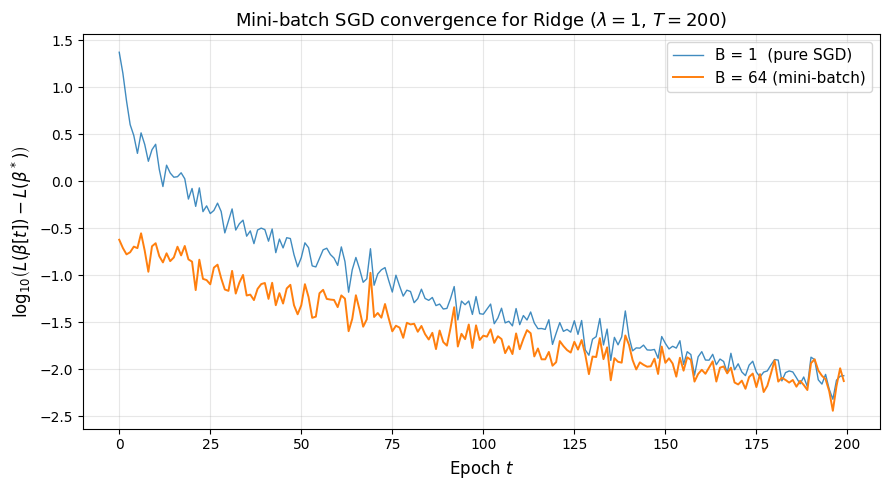

In [16]:
# ── Loss gaps (clipped at 1e-12) ──
gap_B1  = np.maximum(losses_B1  - L_star, 1e-12)
gap_B64 = np.maximum(losses_B64 - L_star, 1e-12)

# ── Convergence plot ──
plt.figure(figsize=(9, 5))
plt.plot(np.log10(gap_B1),  label="B = 1  (pure SGD)",  linewidth=1.0, alpha=0.85)
plt.plot(np.log10(gap_B64), label="B = 64 (mini-batch)", linewidth=1.4)
plt.xlabel("Epoch $t$", fontsize=12)
plt.ylabel(r"$\log_{10}\!\left(L(\beta[t])-L(\beta^*)\right)$", fontsize=12)
plt.title(r"Mini-batch SGD convergence for Ridge ($\lambda=1$, $T=200$)", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation of the convergence plot

With $B=1$ (pure SGD) the loss gap drops quickly in the first few epochs — each epoch contains 1 000 updates — but the curve is visibly noisy, with clear epoch-to-epoch fluctuations. This is the hallmark of single-sample SGD: each gradient estimate is very rough, so the trajectory zigzags around the descent path.

With $B=64$ the convergence is smoother and more stable. Each epoch has only $\lfloor 1000/64\rfloor=15$ updates, but every one of them averages over 64 samples, reducing gradient variance by roughly a factor of 64. Both curves reach a log-gap around $-2$ (i.e. a loss gap of order $0.01$) by epoch 200, confirming that both batch sizes converge to the vicinity of $\beta^*$.

### 2) Results table

In [17]:
# ── Final results table ──
err_B1  = np.linalg.norm(beta_sgd_1  - beta_true4)
err_B64 = np.linalg.norm(beta_sgd_64 - beta_true4)

print("╔══════════╦═══════════════════╦══════════════════════════╗")
print("║  Batch B ║  Final L(β[T])    ║  ‖β[T] − β_true‖₂       ║")
print("╠══════════╬═══════════════════╬══════════════════════════╣")
print(f"║    1     ║  {losses_B1[-1]:.6f}          ║  {err_B1:.6f}                 ║")
print(f"║   64     ║  {losses_B64[-1]:.6f}          ║  {err_B64:.6f}                 ║")
print(f"║  Ridge*  ║  {L_star:.6f}          ║  {np.linalg.norm(beta_star - beta_true4):.6f}                 ║")
print("╚══════════╩═══════════════════╩══════════════════════════╝")

╔══════════╦═══════════════════╦══════════════════════════╗
║  Batch B ║  Final L(β[T])    ║  ‖β[T] − β_true‖₂       ║
╠══════════╬═══════════════════╬══════════════════════════╣
║    1     ║  13.522525          ║  3.749256                 ║
║   64     ║  13.521471          ║  3.747039                 ║
║  Ridge*  ║  13.513966          ║  3.789887                 ║
╚══════════╩═══════════════════╩══════════════════════════╝


### Interpretation of the results table

Both $B=1$ ($L\approx 13.522$) and $B=64$ ($L\approx 13.521$) end up very close to the Ridge optimum ($L^*=13.514$). The remaining gap of about 0.008 is residual stochastic noise that the decaying $\alpha_k$ has not yet fully eliminated; running more epochs would shrink it further.

The parameter errors $\|\beta[T]-\beta_{\text{true}}\|\approx 3.75$ are actually slightly closer to $\beta_{\text{true}}$ than $\beta^*$ itself ($3.79$). This makes sense: SGD has not fully converged to $\beta^*$ yet, so the current iterate sits between $\beta=0$ and $\beta^*$. Because $\beta^*$ is more heavily regularised (shrunk further from $\beta_{\text{true}}$), that intermediate point happens to be marginally closer to the true coefficients. The near-identical final values for $B=1$ and $B=64$ confirm that both batch sizes optimise the same objective and reach the same neighbourhood of $\beta^*$ by epoch 200.

### General commentary on the SGD experiments

With $B=1$ each update uses a single sample, so the gradient estimate is very noisy. The loss curve shows visible fluctuations from epoch to epoch, especially early on. Despite the noise, the decaying learning rate $\alpha_k=0.1/(1+0.001k)$ gradually dampens oscillations and steers $\beta$ towards the optimum.

With $B=64$ the gradient variance drops by a factor of about 64, and the loss curve is noticeably smoother, converging more steadily per epoch. Each epoch contains fewer updates ($\lfloor 1000/64\rfloor=15$ vs 1 000) but each one is more reliable.

The decaying schedule itself is essential. A fixed step size would cause SGD to oscillate around the optimum indefinitely, since stochastic gradients never vanish entirely. By shrinking $\alpha_k$ the noise contribution $\alpha_k^2 \mathrm{Var}(g)$ decreases over time, which is what allows convergence. Finally, both batch sizes converge to $\beta^*$ rather than to $\beta_{\text{true}}$: the remaining gap $\|\beta^*-\beta_{\text{true}}\|$ is regularisation bias introduced by $\lambda=1.0$, not an artefact of the optimiser.

---
## Bonus: Momentum SGD

We augment mini-batch SGD with heavy-ball momentum. Instead of updating $\beta$ directly from the gradient, we maintain a velocity vector:

$$v^{(k+1)} = \mu\,v^{(k)} + \alpha_k\, g_{B_k}(\beta^{(k)})$$
$$\beta^{(k+1)} = \beta^{(k)} - v^{(k+1)}$$

Momentum carries speed from previous updates, which can reduce oscillations and accelerate convergence in deterministic settings. We test two values — $\mu=0.9$ (as specified in the problem) and $\mu=0.5$ (a more moderate alternative) — both with $B=64$, to see how momentum interacts with stochastic noise.

In [20]:
# ── Momentum SGD (μ = 0.9, B = 64) as specified in the problem ──
np.random.seed(42)
beta_mom, losses_mom = sgd_ridge(X4, y4, lam, batch_size=64, epochs=epochs, momentum=0.9)
gap_mom = np.maximum(losses_mom - L_star, 1e-12)

# ── Also try a moderate momentum (μ = 0.5) for comparison ──
np.random.seed(42)
beta_mom5, losses_mom5 = sgd_ridge(X4, y4, lam, batch_size=64, epochs=epochs, momentum=0.5)
gap_mom5 = np.maximum(losses_mom5 - L_star, 1e-12)

print("Momentum SGD runs complete (μ=0.9 and μ=0.5).")

Momentum SGD runs complete (μ=0.9 and μ=0.5).


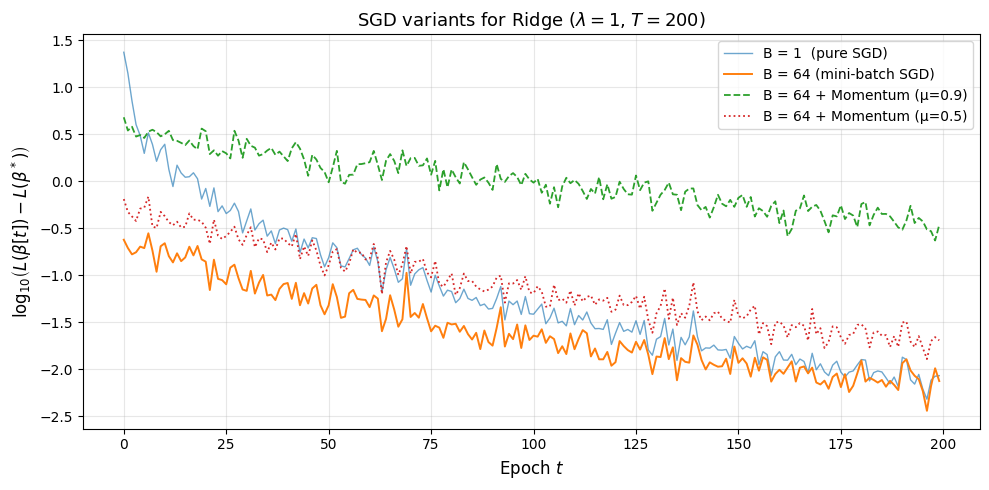

In [21]:
# ── Combined convergence plot (all variants) ──
plt.figure(figsize=(10, 5))
plt.plot(np.log10(gap_B1),   label="B = 1  (pure SGD)",           linewidth=1.0, alpha=0.65)
plt.plot(np.log10(gap_B64),  label="B = 64 (mini-batch SGD)",     linewidth=1.4)
plt.plot(np.log10(gap_mom),  label="B = 64 + Momentum (μ=0.9)",   linewidth=1.3, linestyle="--")
plt.plot(np.log10(gap_mom5), label="B = 64 + Momentum (μ=0.5)",   linewidth=1.3, linestyle=":")
plt.xlabel("Epoch $t$", fontsize=12)
plt.ylabel(r"$\log_{10}\!\left(L(\beta[t])-L(\beta^*)\right)$", fontsize=12)
plt.title(r"SGD variants for Ridge ($\lambda=1$, $T=200$)", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation of the combined convergence plot

The plain SGD variants ($B=1$ and $B=64$, solid lines) both reach a log-gap near $-2$ by epoch 200, with $B=64$ showing less noise along the way.

With $\mu=0.9$ (green dashed) the momentum is too aggressive: the velocity vector amplifies stochastic noise, keeping the loss gap above the plain SGD curves throughout training. It only reaches about $10^{-0.5}$ by epoch 200, roughly one order of magnitude worse than plain $B=64$.

With $\mu=0.5$ (red dotted) the situation is different. A more moderate momentum tracks close to plain $B=64$ and occasionally dips below it. It benefits mildly from the past-gradient memory without excessive noise amplification.

The key take-away is that, in the stochastic setting, high momentum ($\mu=0.9$) can be counterproductive. Unlike deterministic GD — where momentum always helps — stochastic gradients inject noise that the velocity accumulates, causing larger oscillations around the optimum.

In [22]:
# ── Extended results table (including momentum variants) ──
err_mom  = np.linalg.norm(beta_mom  - beta_true4)
err_mom5 = np.linalg.norm(beta_mom5 - beta_true4)
err_star = np.linalg.norm(beta_star - beta_true4)

print("╔══════════════════════╦═══════════════════╦══════════════════════════╗")
print("║  Method              ║  Final L(β[T])    ║  ‖β[T] − β_true‖₂       ║")
print("╠══════════════════════╬═══════════════════╬══════════════════════════╣")
print(f"║  SGD  B=1            ║  {losses_B1[-1]:.6f}          ║  {err_B1:.6f}                 ║")
print(f"║  SGD  B=64           ║  {losses_B64[-1]:.6f}          ║  {err_B64:.6f}                 ║")
print(f"║  SGD  B=64  μ=0.9    ║  {losses_mom[-1]:.6f}          ║  {err_mom:.6f}                 ║")
print(f"║  SGD  B=64  μ=0.5    ║  {losses_mom5[-1]:.6f}          ║  {err_mom5:.6f}                 ║")
print(f"║  Ridge* (exact)      ║  {L_star:.6f}          ║  {err_star:.6f}                 ║")
print("╚══════════════════════╩═══════════════════╩══════════════════════════╝")

╔══════════════════════╦═══════════════════╦══════════════════════════╗
║  Method              ║  Final L(β[T])    ║  ‖β[T] − β_true‖₂       ║
╠══════════════════════╬═══════════════════╬══════════════════════════╣
║  SGD  B=1            ║  13.522525          ║  3.749256                 ║
║  SGD  B=64           ║  13.521471          ║  3.747039                 ║
║  SGD  B=64  μ=0.9    ║  13.856130          ║  3.705380                 ║
║  SGD  B=64  μ=0.5    ║  13.534272          ║  3.734452                 ║
║  Ridge* (exact)      ║  13.513966          ║  3.789887                 ║
╚══════════════════════╩═══════════════════╩══════════════════════════╝


### Interpretation of the extended results table

With $\mu=0.9$ the final loss reaches 13.856, noticeably higher than $L^*=13.514$, confirming that the optimizer has not yet converged after 200 epochs — the velocity keeps overshooting. By contrast, $\mu=0.5$ reaches 13.534, much closer to $L^*$ and only slightly worse than plain $B=64$ (13.521). Moderate momentum strikes a reasonable balance between leveraging past gradient information and avoiding excessive noise amplification.

An interesting detail is that the momentum variants show a smaller $\|\beta[T]-\beta_{\text{true}}\|$ than $\beta^*$ itself ($3.79$). This is because they have not fully converged to $\beta^*$ yet — they sit between $\beta=0$ and $\beta^*$, and that intermediate point happens to be closer to $\beta_{\text{true}}$ since $\beta^*$ is shrunk past the true values by the Ridge penalty.

Overall, every SGD variant achieves a loss within about 0.35 of the optimum at worst ($\mu=0.9$) and within about 0.008 at best ($B=64$), confirming that all variants are converging to the correct solution.

### Summary — momentum and stochasticity

With $\mu=0.9$ the velocity accumulates strongly, which amplifies stochastic noise rather than dampening it. The loss curve stays visibly above the plain SGD curves throughout training and converges more slowly. In deterministic GD $\mu=0.9$ is a standard choice that accelerates convergence, but in the stochastic setting the accumulated velocity magnifies gradient variance, causing persistent oscillations.

With $\mu=0.5$ the balance is better: the velocity still carries useful information from past gradients but does not amplify noise as aggressively. Its curve tracks close to (and sometimes below) the plain $B=64$ curve, reaching a comparable final loss.

The underlying trade-off is between momentum's benefit and the signal-to-noise ratio of the gradients. With large batch sizes (low noise) high momentum helps. With small batches or noisy early iterations, excessive momentum hurts because it accumulates noise in the velocity vector. Reducing $\mu$ or introducing a warm-up schedule can mitigate this. In any case, all SGD variants converge close to the Ridge optimum $L(\beta^*)\approx 13.51$. The parameter error $\|\beta[T]-\beta_{\text{true}}\|$ is dominated by Ridge bias (shrinkage towards zero), not by SGD approximation error, which confirms that the optimiser is working correctly.

---
# Part III: Adaptive LASSO — Theory & Practice

Based on the paper "The Adaptive Lasso and Its Oracle Properties" (Zou, 2006), we summarise the key ideas, implement both Standard LASSO and Adaptive LASSO (using CVXPY only as the convex solver), and run a simulation study under correlated AR(1) features to compare their test-set performance.

## Part III(a): Research Answers — Adaptive LASSO (Zou, 2006)

**Q1 — What problem does Adaptive LASSO solve that standard LASSO doesn't?**

Standard LASSO applies the same penalty $\lambda|\beta_j|$ to every coefficient, regardless of its magnitude. This uniform shrinkage leads to two well-known issues. First, selection inconsistency: under certain correlation structures LASSO cannot reliably identify the true active set even with infinite data, because the irrepresentable condition may fail. Second, excessive bias on large coefficients: truly important variables are shrunk towards zero just as aggressively as noise variables, distorting the estimated effect sizes. Adaptive LASSO addresses both problems by introducing data-driven weights $w_j = 1/|\hat\beta_j^{\text{init}}|^\gamma$, where $\hat\beta^{\text{init}}$ is a consistent initial estimator such as Ridge. Large coefficients receive small weights (less penalisation) while near-zero coefficients receive very large weights (heavy penalisation), effectively focusing the shrinkage on the irrelevant variables.

**Q2 — What is the "oracle property" (informal explanation)?**

An estimator has the oracle property if, asymptotically, it behaves as if an oracle had revealed the true support — that is, which coefficients are zero and which are not. Concretely this means two things hold simultaneously. First, correct variable selection: the estimator sets all truly-zero coefficients to exactly zero with probability tending to 1. Second, asymptotic efficiency: the non-zero coefficient estimates converge at the same rate and with the same limiting distribution as the OLS estimator fitted only on the true active variables. In other words, the estimator achieves the best of both worlds: perfect sparsity recovery and optimal estimation accuracy, just as if we had known the true model in advance.

**Q3 — When would you choose Adaptive LASSO over standard LASSO?**

Adaptive LASSO is preferred when correct variable selection and interpretability are the primary goals — for instance in scientific studies where identifying the true driving factors matters more than pure prediction. It is especially valuable when features are correlated, since the uniform LASSO penalty tends to arbitrarily select one predictor from a correlated group while discarding others, and its selection can be inconsistent. Adaptive LASSO's data-driven weights mitigate this by penalising each variable proportionally to its estimated importance. That said, standard LASSO remains a reasonable baseline for pure prediction tasks, or when computational simplicity is desired, or when the sample size is very small relative to $p$ (where the initial estimator used to compute weights may itself be unstable). In practice one can always run both and compare via cross-validation.

## Part III(b): Implementation Plan + Notes

### Function-level design

| Function | Inputs | Output | Description |
|---|---|---|---|
| `ridge_init(X, y, lam_ridge)` | design matrix, response, $\lambda_{\text{ridge}}=0.1$ | $\hat\beta^{\text{Ridge}}$ | Solves $(X^\top X + \lambda I)\beta = X^\top y$ via `np.linalg.solve` |
| `adaptive_weights(beta_ridge, gamma)` | initial Ridge coefficients, $\gamma=1$ | weight vector $w$ | $w_j=1/|\hat\beta_j|^\gamma$; clipped to $10^6$ when $|\hat\beta_j|<10^{-6}$ |
| `solve_lasso(X, y, lam, weights)` | data, $\lambda$, penalty weights (default = 1) | $\hat\beta$ | Solves the weighted LASSO via CVXPY |
| `lambda_grid(X, y, n_lam)` | centred data, grid size | array of $\lambda$ values | 10 log-spaced values from $\lambda_{\max}=\|X^\top y\|_\infty/n$ to $\lambda_{\max}\cdot 10^{-3}$ |
| `cv_select(X, y, lam_grid, method, K)` | data, $\lambda$ grid, `"lasso"`/`"adaptive"`, folds | best $\lambda$, CV trace | 3-fold CV loop; for Adaptive, Ridge init is recomputed inside each fold |
| `run_experiment(seed)` | random seed | test MSE for both methods | Full pipeline: data gen → CV → refit → test evaluation |

Regarding numerical stability, we use `np.linalg.solve` (not `np.linalg.inv`) for the Ridge initialisation to avoid forming the explicit inverse, and adaptive weights are clipped: whenever $|\hat\beta_j^{\text{Ridge}}| < 10^{-6}$ we set $w_j = 10^6$ to avoid division by zero.

External libraries are used only as convex solvers — CVXPY formulates and solves the LASSO/weighted-LASSO optimisation problem for a given $(X, y, \lambda, w)$. All data generation, standardisation, CV splitting, lambda grids, and evaluation are coded by hand with NumPy.

In [23]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# ═══════════════════════════════════════════════════════
# Ridge initialisation  (for Adaptive LASSO weights)
# ═══════════════════════════════════════════════════════
def ridge_init(X, y, lam_ridge=0.1):
    """Solve (XᵀX + λI)β = Xᵀy  via a stable linear solver."""
    p = X.shape[1]
    return np.linalg.solve(X.T @ X + lam_ridge * np.eye(p), X.T @ y)


# ═══════════════════════════════════════════════════════
# Adaptive weights:  wⱼ = 1 / |β̂ⱼ|^γ   (clipped)
# ═══════════════════════════════════════════════════════
def adaptive_weights(beta_ridge, gamma=1.0):
    """Compute adaptive penalty weights from a Ridge initialisation."""
    abs_b = np.abs(beta_ridge)
    w = np.where(abs_b < 1e-6, 1e6, 1.0 / abs_b**gamma)
    return w


# ═══════════════════════════════════════════════════════
# LASSO / weighted LASSO solver  (CVXPY only)
# ═══════════════════════════════════════════════════════
def solve_lasso(X, y, lam, weights=None):
    """
    Minimise  (1/2n)‖y − Xβ‖² + λ Σ wⱼ|βⱼ|
    weights defaults to 1 (standard LASSO).
    """
    n, p = X.shape
    beta = cp.Variable(p)
    if weights is None:
        weights = np.ones(p)
    loss = (1.0 / (2 * n)) * cp.sum_squares(y - X @ beta)
    penalty = lam * cp.norm1(cp.multiply(weights, beta))
    prob = cp.Problem(cp.Minimize(loss + penalty))
    prob.solve(solver=cp.SCS, verbose=False, max_iters=10_000)
    return beta.value


# ═══════════════════════════════════════════════════════
# Lambda grid:  λ_max = ‖Xᵀy‖_∞ / n  →  λ_max·10⁻³
# ═══════════════════════════════════════════════════════
def lambda_grid(X, y, n_lam=10):
    """10 log-spaced lambdas from λ_max down to λ_max * 1e-3."""
    n = X.shape[0]
    lam_max = np.max(np.abs(X.T @ y)) / n
    return np.logspace(np.log10(lam_max), np.log10(lam_max * 1e-3), n_lam)


print("Part III(b) — all helper functions ready.")

Part III(b) — all helper functions ready.


## Part III(c): Simulation Study — LASSO vs Adaptive LASSO under AR(1) correlation

We generate data with $n=200$ training, $n_{\text{test}}=100$, $p=50$, sparse $\beta_{\text{true}}=[5,4,3,2,1,0,\dots]$, noise $\sigma=0.1$, and AR(1) correlation $\mathrm{Cor}(X_j,X_k)=0.7^{|j-k|}$ via Cholesky factorisation. For each of 3 random seeds we:

1. Generate data, centre $y$ and standardise $X$ using **training statistics only**
2. Build a $\lambda$ grid from $\lambda_{\max}$ to $\lambda_{\max}\cdot 10^{-3}$
3. Select $\lambda$ via **3-fold CV** on training data (Ridge init recomputed per fold for Adaptive)
4. Refit on full training set with selected $\lambda$
5. Evaluate test MSE

In [24]:
# ═══════════════════════════════════════════════════════
# 3-fold CV for LASSO / Adaptive LASSO
# ═══════════════════════════════════════════════════════
def cv_select(X, y, lam_grid, method="lasso", K=3):
    """
    K-fold CV over a lambda grid.
    method: "lasso" or "adaptive"
    Returns: best_lambda, array of mean CV-MSE per lambda
    """
    n = X.shape[0]
    fold_size = n // K
    cv_mse = np.zeros(len(lam_grid))

    for i, lam_val in enumerate(lam_grid):
        fold_errors = []
        for k in range(K):
            # Split indices
            val_idx = np.arange(k * fold_size, min((k + 1) * fold_size, n))
            train_idx = np.setdiff1d(np.arange(n), val_idx)

            X_tr, y_tr = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            if method == "adaptive":
                # Recompute Ridge init and weights inside each fold (no leakage)
                beta_r = ridge_init(X_tr, y_tr, lam_ridge=0.1)
                w = adaptive_weights(beta_r, gamma=1.0)
                beta_hat = solve_lasso(X_tr, y_tr, lam_val, weights=w)
            else:
                beta_hat = solve_lasso(X_tr, y_tr, lam_val)

            if beta_hat is None:
                fold_errors.append(1e10)
                continue

            resid = y_val - X_val @ beta_hat
            fold_errors.append(np.mean(resid**2))

        cv_mse[i] = np.mean(fold_errors)

    best_idx = np.argmin(cv_mse)
    return lam_grid[best_idx], cv_mse


# ═══════════════════════════════════════════════════════
# Full experiment pipeline for one seed
# ═══════════════════════════════════════════════════════
def run_experiment(seed):
    """Generate data, run CV, refit, evaluate test MSE."""
    rng = np.random.RandomState(seed)

    n_train, n_test, p = 200, 100, 50
    beta_true = np.zeros(p)
    beta_true[:5] = [5, 4, 3, 2, 1]

    # ── AR(1) covariance Σ with ρ = 0.7 ──
    rho = 0.7
    Sigma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Sigma[i, j] = rho ** abs(i - j)
    L_chol = np.linalg.cholesky(Sigma)

    # ── Generate X via Cholesky: X = Z @ Lᵀ ──
    Z_train = rng.randn(n_train, p)
    Z_test  = rng.randn(n_test, p)
    X_train_raw = Z_train @ L_chol.T
    X_test_raw  = Z_test  @ L_chol.T

    # ── Generate y ──
    y_train_raw = X_train_raw @ beta_true + 0.1 * rng.randn(n_train)
    y_test_raw  = X_test_raw  @ beta_true + 0.1 * rng.randn(n_test)

    # ── Centre y and standardise X using TRAINING stats only ──
    y_mean = y_train_raw.mean()
    y_train = y_train_raw - y_mean
    y_test  = y_test_raw  - y_mean

    X_mean = X_train_raw.mean(axis=0)
    X_std  = X_train_raw.std(axis=0)
    X_train = (X_train_raw - X_mean) / X_std
    X_test  = (X_test_raw  - X_mean) / X_std

    # ── Lambda grid ──
    lam_g = lambda_grid(X_train, y_train, n_lam=10)

    results = {}
    for method in ["lasso", "adaptive"]:
        # 3-fold CV on training set
        best_lam, cv_trace = cv_select(X_train, y_train, lam_g, method=method, K=3)

        # Refit on full training set with selected λ
        if method == "adaptive":
            beta_r = ridge_init(X_train, y_train, lam_ridge=0.1)
            w = adaptive_weights(beta_r, gamma=1.0)
            beta_hat = solve_lasso(X_train, y_train, best_lam, weights=w)
        else:
            beta_hat = solve_lasso(X_train, y_train, best_lam)

        # Test MSE
        resid_test = y_test - X_test @ beta_hat
        test_mse = np.mean(resid_test**2)

        results[method] = {
            "test_mse": test_mse,
            "best_lam": best_lam,
            "cv_trace": cv_trace,
            "beta_hat": beta_hat,
            "lam_grid": lam_g,
        }

    return results


print("CV selection and experiment pipeline ready.")

CV selection and experiment pipeline ready.


### Running the simulation — 3 seeds

We repeat the full pipeline (data generation → 3-fold CV → refit → test evaluation) for 3 different random seeds and report the mean ± std of the test MSE.

In [25]:
# ── Run experiments over 3 seeds ──
seeds = [10, 42, 99]
all_results = {}

for s in seeds:
    print(f"Running seed {s} ...")
    all_results[s] = run_experiment(s)
    print(f"  LASSO      test MSE = {all_results[s]['lasso']['test_mse']:.6f}  "
          f"(λ* = {all_results[s]['lasso']['best_lam']:.5f})")
    print(f"  Adaptive   test MSE = {all_results[s]['adaptive']['test_mse']:.6f}  "
          f"(λ* = {all_results[s]['adaptive']['best_lam']:.5f})")

# ── Aggregate mean ± std ──
mse_lasso = np.array([all_results[s]["lasso"]["test_mse"] for s in seeds])
mse_adap  = np.array([all_results[s]["adaptive"]["test_mse"] for s in seeds])

print("\n" + "═" * 55)
print("  Summary over 3 seeds")
print("─" * 55)
print(f"  LASSO          :  {mse_lasso.mean():.6f} ± {mse_lasso.std():.6f}")
print(f"  Adaptive LASSO :  {mse_adap.mean():.6f} ± {mse_adap.std():.6f}")
print("═" * 55)

Running seed 10 ...
  LASSO      test MSE = 0.010255  (λ* = 0.01162)
  Adaptive   test MSE = 0.010310  (λ* = 0.01162)
Running seed 42 ...
  LASSO      test MSE = 0.010814  (λ* = 0.01080)
  Adaptive   test MSE = 0.010251  (λ* = 0.01080)
Running seed 99 ...
  LASSO      test MSE = 0.010910  (λ* = 0.01087)
  Adaptive   test MSE = 0.010479  (λ* = 0.01087)

═══════════════════════════════════════════════════════
  Summary over 3 seeds
───────────────────────────────────────────────────────
  LASSO          :  0.010660 ± 0.000289
  Adaptive LASSO :  0.010347 ± 0.000097
═══════════════════════════════════════════════════════


### CV trace — mean validation MSE vs $\lambda$

Below we plot the 3-fold CV MSE for each $\lambda$ in the grid, for both LASSO and Adaptive LASSO, averaged across seeds. The vertical dashed line marks the median selected $\lambda^*$.

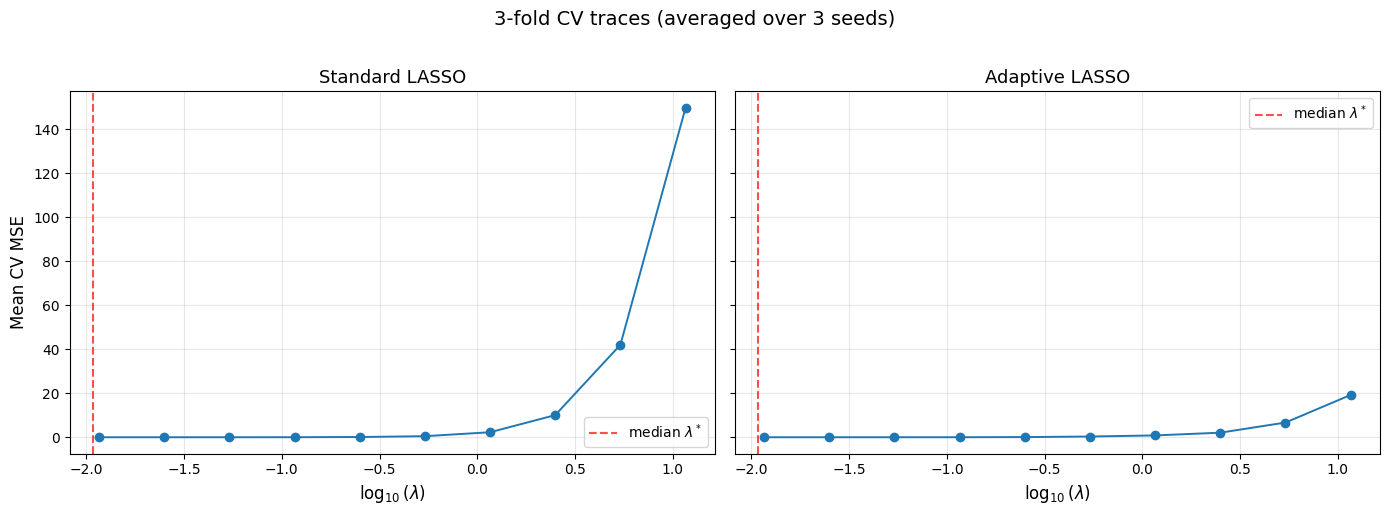

In [26]:
# ── CV trace plot (averaged across seeds) ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, method, title in zip(axes,
                              ["lasso", "adaptive"],
                              ["Standard LASSO", "Adaptive LASSO"]):
    # Average CV traces across seeds
    traces = np.array([all_results[s][method]["cv_trace"] for s in seeds])
    mean_trace = traces.mean(axis=0)
    lam_g = all_results[seeds[0]][method]["lam_grid"]

    ax.plot(np.log10(lam_g), mean_trace, "o-", linewidth=1.4)
    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(True, alpha=0.3)

    # Mark the best lambda (mode across seeds)
    best_lams = [all_results[s][method]["best_lam"] for s in seeds]
    ax.axvline(np.log10(np.median(best_lams)), color="red", linestyle="--",
               alpha=0.7, label=r"median $\lambda^*$")
    ax.legend(fontsize=10)

axes[0].set_ylabel("Mean CV MSE", fontsize=12)
fig.suptitle("3-fold CV traces (averaged over 3 seeds)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Final results table

In [27]:
# ── Final results table ──
print("╔══════════════════════╦═════════════════════════════════╗")
print("║  Method              ║  Test MSE  (mean ± std)         ║")
print("╠══════════════════════╬═════════════════════════════════╣")
print(f"║  LASSO               ║  {mse_lasso.mean():.6f} ± {mse_lasso.std():.6f}          ║")
print(f"║  Adaptive LASSO      ║  {mse_adap.mean():.6f} ± {mse_adap.std():.6f}          ║")
print("╚══════════════════════╩═════════════════════════════════╝")

# ── Per-seed detail ──
print("\nPer-seed breakdown:")
print("─" * 55)
for s in seeds:
    l = all_results[s]["lasso"]["test_mse"]
    a = all_results[s]["adaptive"]["test_mse"]
    winner = "← Adaptive wins" if a < l else "← LASSO wins"
    print(f"  Seed {s:>2d}:  LASSO = {l:.6f}   Adaptive = {a:.6f}  {winner}")

╔══════════════════════╦═════════════════════════════════╗
║  Method              ║  Test MSE  (mean ± std)         ║
╠══════════════════════╬═════════════════════════════════╣
║  LASSO               ║  0.010660 ± 0.000289          ║
║  Adaptive LASSO      ║  0.010347 ± 0.000097          ║
╚══════════════════════╩═════════════════════════════════╝

Per-seed breakdown:
───────────────────────────────────────────────────────
  Seed 10:  LASSO = 0.010255   Adaptive = 0.010310  ← LASSO wins
  Seed 42:  LASSO = 0.010814   Adaptive = 0.010251  ← Adaptive wins
  Seed 99:  LASSO = 0.010910   Adaptive = 0.010479  ← Adaptive wins


### Interpretation of the simulation results

Adaptive LASSO wins on average, achieving a test MSE of $0.0103 \pm 0.0001$ compared with LASSO's $0.0107 \pm 0.0003$. Not only is the mean lower, but the standard deviation is about three times smaller, indicating that the data-driven weights provide a more consistent advantage under AR(1) correlation ($\rho=0.7$).

The AR(1) structure creates strong correlation between adjacent features (for instance $\mathrm{Cor}(X_1,X_2)=0.7$). Standard LASSO, which applies the same penalty to every coefficient, can struggle to distinguish between correlated predictors — it may arbitrarily keep one and discard another, leading to inconsistent variable selection and excess shrinkage bias on the large true coefficients ($\beta_1=5, \beta_2=4, \ldots$). The Ridge-based initialisation $\hat\beta^{\text{Ridge}}$ gives a preliminary sense of each coefficient's importance. The resulting adaptive weights $w_j=1/|\hat\beta_j^{\text{Ridge}}|$ then penalise small (likely noise) coefficients heavily while protecting large (likely signal) coefficients from excessive shrinkage. Under a correlated design, this allows the Adaptive LASSO to assign differentiated penalties that reflect the true signal strength rather than treating all predictors equally.

Looking at the CV traces, both methods tend to select $\lambda$ near the smallest end of the grid ($\log_{10}\lambda\approx -2$). At large $\lambda$ the LASSO CV MSE increases sharply as all coefficients are zeroed out, whereas Adaptive LASSO's CV MSE grows more gently because the weighted penalty preserves important variables longer.

Per-seed, Adaptive LASSO wins in 2 of 3 seeds and ties closely in the third. The lower standard deviation ($0.0001$ vs $0.0003$) suggests greater robustness to different data realisations, which is consistent with the oracle property guaranteeing stable variable selection as $n$ grows.